In [1]:
!pip install medmnist
!pip install pywavelets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pywt
from torchvision import transforms
from torch.utils.data import DataLoader
from medmnist import INFO, PathMNIST

# INFO del dataset
data_flag = 'pathmnist'
info = INFO[data_flag]
DataClass = getattr(__import__('medmnist'), info['python_class'])

# Transformación para pasar a tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Cargar dataset de entrenamiento
train_dataset = DataClass(split='train', transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)



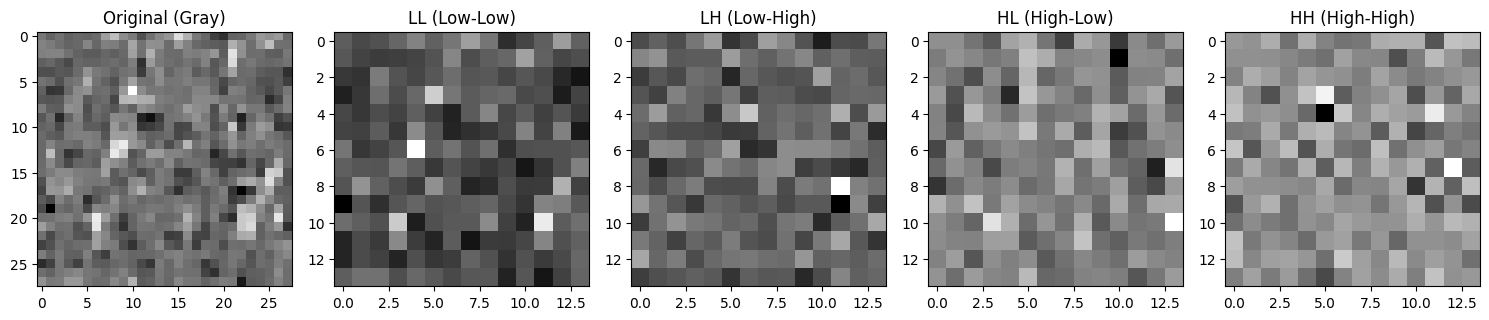

In [6]:
def apply_dwt(image_tensor):
    # Promedio sobre canales → escala de grises: [3, 28, 28] → [28, 28]
    grayscale_image = image_tensor.mean(dim=0).numpy()

    # Aplicar la transformada wavelet (nivel 1, wavelet Haar)
    coeffs2 = pywt.dwt2(grayscale_image, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Retornar como tensores (opcional: normalizar si lo necesitas)
    return {
        'LL': torch.tensor(LL, dtype=torch.float32),
        'LH': torch.tensor(LH, dtype=torch.float32),
        'HL': torch.tensor(HL, dtype=torch.float32),
        'HH': torch.tensor(HH, dtype=torch.float32),
    }

# 🎨 Visualización de resultados
for images, labels in train_loader:
    image = images[0]  # Primer ejemplo del batch
    coeffs = apply_dwt(image)

    # Mostrar imagen original + subbandas
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    axs[0].imshow(image.mean(dim=0), cmap='gray')
    axs[0].set_title("Original (Gray)")
    axs[1].imshow(coeffs['LL'], cmap='gray')
    axs[1].set_title("LL (Low-Low)")
    axs[2].imshow(coeffs['LH'], cmap='gray')
    axs[2].set_title("LH (Low-High)")
    axs[3].imshow(coeffs['HL'], cmap='gray')
    axs[3].set_title("HL (High-Low)")
    axs[4].imshow(coeffs['HH'], cmap='gray')
    axs[4].set_title("HH (High-High)")
    plt.tight_layout()
    plt.show()
    break  # solo mostrar una imagen

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class DWTEmbedding(nn.Module):
    def __init__(self, patch_size=2, embed_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        # Cada imagen tendrá 4 canales (LL, LH, HL, HH)
        self.proj = nn.Linear(4 * patch_size * patch_size, embed_dim)

    def forward(self, dwt_dict):
        # Concatenar subbandas: tensor shape [4, 14, 14]
        x = torch.stack([
            dwt_dict['LL'], dwt_dict['LH'],
            dwt_dict['HL'], dwt_dict['HH']
        ], dim=0)  # Shape: [4, 14, 14]

        # Asegurar shape para batch -> [1, C, H, W]
        x = x.unsqueeze(0)

        # Extraer patches
        patches = x.unfold(1, 4, 4).unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(-1, 4 * self.patch_size * self.patch_size)  # [num_patches, flattened_patch_size]

        # Proyectar a embeddings
        tokens = self.proj(patches)  # [num_patches, embed_dim]

        # Opcional: añadir positional encoding
        # Aquí simplemente devolvemos los tokens
        return tokens  # [N_patches, embed_dim]


In [11]:
# Crear módulo de embedding
embedder = DWTEmbedding(patch_size=2, embed_dim=64)

# Obtener una imagen del loader
for images, labels in train_loader:
    image = images[0]
    coeffs = apply_dwt(image)
    token_sequence = embedder(coeffs)
    print(f"Shape de los tokens: {token_sequence.shape}")  # → [N_patches, 64]
    break


Shape de los tokens: torch.Size([49, 64])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pywt

# ---------- Paso 1: DWT ----------
def apply_dwt(image_tensor):
    grayscale_image = image_tensor.mean(dim=0).numpy()
    coeffs2 = pywt.dwt2(grayscale_image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    return {
        'LL': torch.tensor(LL, dtype=torch.float32),
        'LH': torch.tensor(LH, dtype=torch.float32),
        'HL': torch.tensor(HL, dtype=torch.float32),
        'HH': torch.tensor(HH, dtype=torch.float32),
    }

# ---------- Paso 2: Embedding ----------
class DWTEmbedding(nn.Module):
    def __init__(self, patch_size=2, embed_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = nn.Linear(4 * patch_size * patch_size, embed_dim)

    def forward(self, dwt_dict):
        x = torch.stack([
            dwt_dict['LL'], dwt_dict['LH'],
            dwt_dict['HL'], dwt_dict['HH']
        ], dim=0)  # Shape: [4, 14, 14]
        x = x.unsqueeze(0)  # [1, 4, 14, 14]
        patches = x.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(-1, 4 * self.patch_size * self.patch_size)
        tokens = self.proj(patches)
        return tokens  # [N_patches, embed_dim]

# ---------- Paso 3: Modelo completo ----------
class DWTFormerMini(nn.Module):
    def __init__(self, num_classes=9, patch_size=2, embed_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.embedding = DWTEmbedding(patch_size=patch_size, embed_dim=embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=128, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_head = nn.Linear(embed_dim, num_classes)

    def forward(self, image_tensor):
        dwt_output = apply_dwt(image_tensor)                # dict -> LL, LH, HL, HH
        tokens = self.embedding(dwt_output).unsqueeze(0)    # [1, N_patches, embed_dim]
        x = self.transformer(tokens)                        # [1, N_patches, embed_dim]
        x_cls = x.mean(dim=1)                               # agregación global (también puedes usar x[:, 0] tipo ViT)
        out = self.cls_head(x_cls)                          # [1, num_classes]
        return out


In [13]:
model = DWTFormerMini(num_classes=9)
model.eval()

# Coger imagen de ejemplo
for images, labels in train_loader:
    image = images[0]
    output = model(image)
    print("Predicción (logits):", output)
    print("Predicción (clase):", output.argmax(dim=1))
    break


Predicción (logits): tensor([[ 0.4778, -0.1597, -0.5982,  0.3387,  0.0241,  0.5272, -0.0298,  0.0899,
          0.1951]], grad_fn=<AddmmBackward0>)
Predicción (clase): tensor([5])
